#  Ultimate Technologies Inc. Take-Home Challenge
## August Perez

Springboard Data Science track unit 37.2

In [1]:
#imports

# data manipulation and math

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import datetime as dt

# plotting and visualization

import matplotlib.pyplot as plt
import seaborn as sns

# modeling & pre-processing
    #commenting out since not necessary for this part of the project
#    import sklearn.model_selection
#    from sklearn.model_selection import train_test_split
#    from sklearn.model_selection import KFold
#    import sklearn.preprocessing
#    import sklearn.metrics

import warnings
    #reminder code so I can ignore warnings for single code cells:
    # warnings.filterwarnings('ignore')
    # warnings.resetwarnings()

# Part 1 - Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

**Aggregate these login counts based on 15minute time intervals**, 

and **visualize and describe the resulting time series** of login counts in **ways that best characterize the underlying patterns of the demand**. 

Please **report/illustrate important features of the demand**, such as daily cycles. If there are **data quality issues, please report them**.

In [2]:
#load data

df_logins = pd.read_json('logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## aggregate by 15min intervals

In [4]:
df_logins.set_index('login_time', inplace=True)

In [ ]:
aggregated = df_logins.resample('15min').size()
aggregated

In [6]:
#back to a dataframe instead of a series
df_aggregated = aggregated.to_frame(name='login_count')
df_aggregated.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [8]:
df_aggregated.reset_index(drop=False, inplace=True)
df_aggregated.head()

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


## Visualize & describe

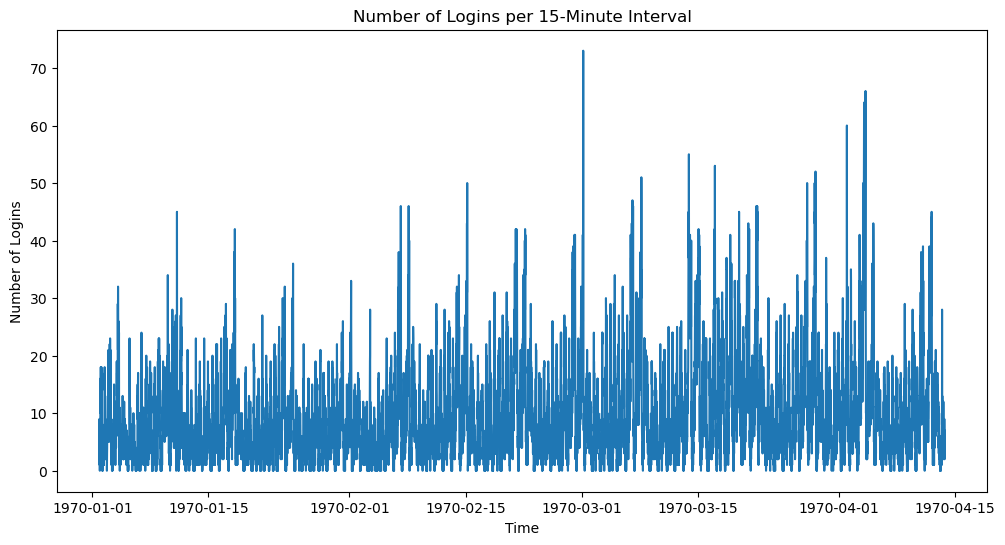

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='login_time', y='login_count', data=df_aggregated)
plt.title('Number of Logins per 15-Minute Interval')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.show()

# Part 2 ‐ Experiment and metrics design

# Part 3 ‐ Predictive modeling